In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_ml as pdml
import xgboost as xgb
import lightgbm as lgb 

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

from sklearn import preprocessing

from xgboost import plot_importance

%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [334]:
#Read the prepared dataset
loans = pd.read_csv('prepared_loans.csv')
#create pandas_ml ModelFrame object
loans_mf = pdml.ModelFrame(loans.drop(['grade', 'roi_inv'], axis = 1))

In [335]:
#Split into training and test data sets
train_loans, test_loans = loans_mf.model_selection.train_test_split(test_size = 0.20, random_state = 6)
print("Train dataset\n", train_loans.target.value_counts())
print("\nTest dataset\n", test_loans.target.value_counts())

Train dataset
 0    263176
1     79028
Name: .target, dtype: int64

Test dataset
 0    65649
1    19903
Name: .target, dtype: int64


In [336]:
#Creating a SMOTE oversampled training dataset as well.
sampler = train_loans.imbalance.over_sampling.SMOTE()
sampled_lr_loans = train_loans.fit_sample(sampler)
print ("Over sampled Train dataset\n" , sampled_lr_loans.target.value_counts())

Over sampled Train dataset
 1    263176
0    263176
Name: .target, dtype: int64


In [337]:
# Create a smaller size training set for cross validation & hyper parameter tuning
loans_subset = pdml.ModelFrame(loans.sample(60000))
mini_train_loans, mini_test_loans = loans_subset.model_selection.train_test_split(test_size = 0.20, random_state = 6)


In [338]:
#Defining a method to compute all relevant train / test scores for a fitted model.
def score_the_model(train_mf, test_mf, alg, model_key, use_PredictProba = True, scale = False) :
    print("-----------------------------------------------------------------------------------------------------------")
    print(model_key)
    if(scale == True) :
        train_data = preprocessing.scale(train_mf.data)
        test_data = preprocessing.scale(test_mf.data)
    else :
        train_data = train_mf.data
        test_data = test_mf.data
    if(use_PredictProba) :
        train_predict_prob = alg.predict_proba(train_data)[:,1]
        test_predict_prob = alg.predict_proba(test_data)[:,1]
    else :
        train_predict_prob=alg.predict(train_data)
        test_predict_prob=alg.predict(test_data)
    #Using a lower probability threshold of 0.4 to mark border case Bads as Bads
    train_predicted = np.array([0 if p < 0.4 else 1 for p in train_predict_prob])
    test_predicted = np.array([0 if p < 0.4 else 1 for p in test_predict_prob])

    tr_accuracy = accuracy_score(np.array(train_mf.target), train_predicted)
    te_accuracy = accuracy_score(np.array(test_mf.target), test_predicted)
    
    tr_auc = roc_auc_score(np.array(train_mf.target), np.array(train_predict_prob), average='weighted')
    te_auc = roc_auc_score(np.array(test_mf.target), np.array(test_predict_prob), average = 'weighted')
    
    tr_prec = average_precision_score(np.array(train_mf.target), np.array(train_predict_prob), average='weighted')
    te_prec = average_precision_score(np.array(test_mf.target), np.array(test_predict_prob), average = 'weighted')
    
    tr_f1 = f1_score(np.array(train_mf.target), np.array(train_predicted), average = 'weighted')
    te_f1 = f1_score(np.array(test_mf.target), np.array(test_predicted), average = 'weighted')

    prec, recall, f1, support = precision_recall_fscore_support(np.array(test_mf.target), np.array(test_predicted))
    te_0_prec, te_1_prec = prec[0], prec[1]
    te_0_rec, te_1_rec = recall[0], recall[1]
    te_0_f1, te_1_f1 = f1[0], f1[1]
    
    scores = pd.Series([model_key,tr_accuracy,te_accuracy,tr_auc,te_auc,tr_prec,te_prec,tr_f1,te_f1, te_0_prec,te_1_prec,
                         te_0_rec, te_1_rec,te_0_f1, te_1_f1], ['Model','Accuracy (Train)', 'Accuracy (Test)', 'AUC (Train)', 'AUC (Test)',
                                        'Precision (Train)', 'Precision (Test)','F1-Weighted (Train)', 'F1-Weighted (Test)',
                                        'Label-Good Precision (Test)','Label-Bad Precision (Test)', 'Label-Good Recall (Test)',
                                        'Label-Bad Recall (Test)','Label-Good F1 (Test)','Label-Bad F1 (Test)'  ] )
    
    return scores

In [339]:
# A Dataframe to hold all the model scores
allmodelscores = pd.DataFrame()

## Random Forest

In [340]:
#Random Forest estimator fit on regular training dataset
rf_est = loans_mf.ensemble.RandomForestClassifier(n_estimators = 60, criterion = 'gini', class_weight = 'balanced')
rf_est.fit(train_loans.data, train_loans.target)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [341]:
allmodelscores = allmodelscores.append(score_the_model(train_loans, test_loans, rf_est, model_key='Random Forest'), ignore_index=True)
allmodelscores.tail(1)

-----------------------------------------------------------------------------------------------------------
Random Forest


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
0,0.714497,1.0,0.764646,0.99998,0.73955,0.99998,0.355288,0.48976,0.278752,0.856048,0.806599,0.911956,Random Forest,0.423052,1.0


In [342]:
#Random Forest estimator fit on oversampled training dataset
rf_est_smpled = loans_mf.ensemble.RandomForestClassifier(n_estimators = 60, criterion = 'gini', class_weight = 'balanced')
rf_est_smpled.fit(sampled_lr_loans.data, sampled_lr_loans.target)

allmodelscores = allmodelscores.append(score_the_model(sampled_lr_loans, test_loans, rf_est_smpled, model_key='Random Forest with Oversampling'), ignore_index=True)
allmodelscores.tail(1)

-----------------------------------------------------------------------------------------------------------
Random Forest with Oversampling


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
1,0.714236,1.0,0.749766,0.99997,0.742852,0.99997,0.421155,0.455945,0.391298,0.840382,0.823064,0.858444,Random Forest with Oversampling,0.42444,1.0


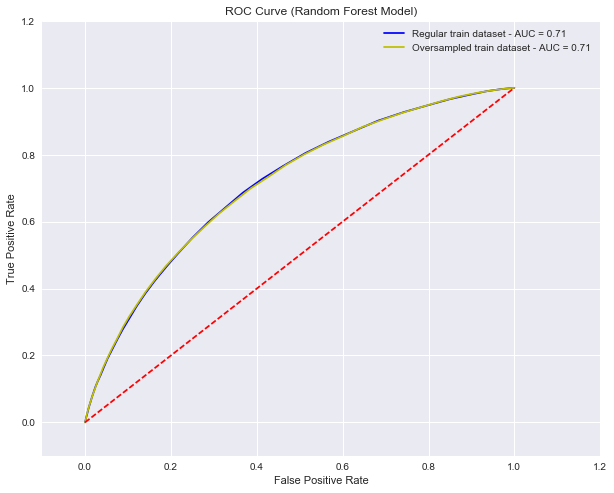

In [343]:
# ROC Curve
rf_fpr, rf_tpr, rf_threshold = roc_curve(np.array(test_loans.target),rf_est.predict_proba(test_loans.data)[:,1] )
rf_fpr_ovr, rf_tpr_ovr, rf_threshold_over = roc_curve(np.array(test_loans.target),rf_est_smpled.predict_proba(test_loans.data)[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
rf_roc_auc_ovr = auc(rf_fpr_ovr, rf_tpr_ovr)
plt.title('ROC Curve (Random Forest Model)')
plt.plot(rf_fpr, rf_tpr, 'b', label='Regular train dataset - AUC = %0.2f'% rf_roc_auc)
plt.plot(rf_fpr_ovr, rf_tpr_ovr, 'y', label='Oversampled train dataset - AUC = %0.2f'% rf_roc_auc_ovr)
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig("RFROC.png")

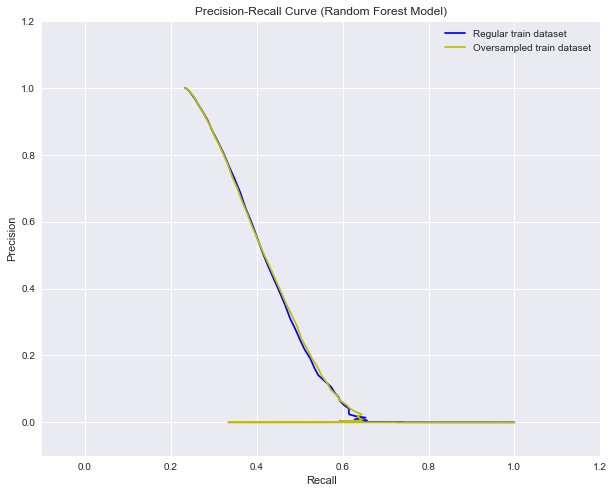

In [344]:
# Precision-Recall Curve
rf_prec, rf_rec, rf_threshold = precision_recall_curve(np.array(test_loans.target),rf_est.predict_proba(test_loans.data)[:,1] )
rf_prec_ovr, rf_rec_ovr, rf_threshold_over = precision_recall_curve(np.array(test_loans.target),rf_est_smpled.predict_proba(test_loans.data)[:,1])
plt.title('Precision-Recall Curve (Random Forest Model)')
plt.plot(rf_prec, rf_rec, 'b', label='Regular train dataset')
plt.plot(rf_prec_ovr, rf_rec_ovr, 'y', label='Oversampled train dataset')
plt.legend(loc='best')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

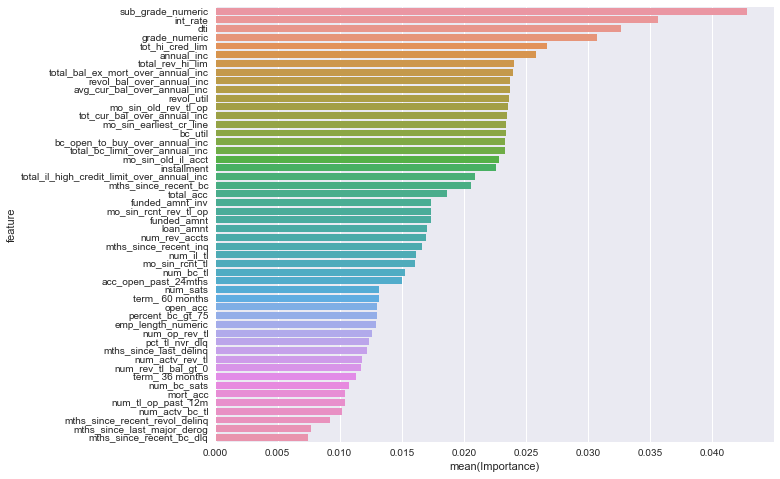

In [345]:
rf_importance = rf_est.feature_importances_
rf_importance = pd.DataFrame(rf_importance, index=train_loans.data.columns, 
                          columns=["Importance"])
rf_importance.sort_values('Importance', ascending = False, inplace=True)
rf_importance['feature'] = rf_importance.index
sns.barplot(y = 'feature', x = 'Importance', data= rf_importance.head(50) )
plt.savefig("RF-feature.png")

## Light GBM

In [346]:
# Fit Light GBM on the regular train_loans, parameter values selected as per the tuning results from next section
train_lgb = lgb.Dataset(train_loans.data, label=train_loans.target)
param = {'objective':'binary', 'metric' :['auc', 'f1_weighted'], 
        'num_leaves': 300, 'max_depth' : 5, 'learning_rate': 0.05, 'max_bin': 100, 'min_data_in_leaf' : 300}
num_round=500

lgbm=lgb.train(param,train_lgb,num_round)

In [347]:
#Score the model and record the score
score = score_the_model(train_loans, test_loans, lgbm, model_key= 'Light GBM', use_PredictProba=False)
allmodelscores = allmodelscores.append([score], ignore_index=True)
allmodelscores.tail(1)

-----------------------------------------------------------------------------------------------------------
Light GBM


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
2,0.742971,0.768419,0.773039,0.784506,0.756491,0.769141,0.418322,0.518029,0.350801,0.859014,0.820726,0.90105,Light GBM,0.466543,0.507788


In [348]:
# Fit and score Light GBM on the over sampled training dataset.
# Fit Light GBM on the regular train_loans, parameter values selected as per the tuning results from next section
smpled_train_lgb = lgb.Dataset(sampled_lr_loans.data, label=sampled_lr_loans.target)
param = {'objective':'binary', 'metric' :['auc', 'f1_weighted'], 
        'num_leaves': 300, 'max_depth' : 5, 'learning_rate': 0.05, 'max_bin': 100, 'min_data_in_leaf' : 300}
num_round=500

lgbm_smpled=lgb.train(param,smpled_train_lgb,num_round)
score = score_the_model(sampled_lr_loans, test_loans, lgbm_smpled, model_key= 'Light GBM with Oversampling', use_PredictProba=False)
allmodelscores = allmodelscores.append([score], ignore_index=True)
allmodelscores.tail(1)

-----------------------------------------------------------------------------------------------------------
Light GBM with Oversampling


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
3,0.74069,0.926175,0.772852,0.85595,0.754941,0.855574,0.410675,0.517977,0.3402,0.859313,0.818819,0.90402,Light GBM with Oversampling,0.462486,0.944234


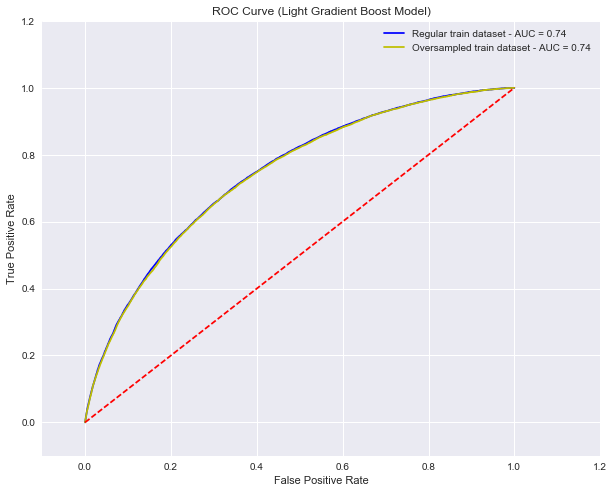

In [349]:
# ROC Curve
lgbm_fpr, lgbm_tpr, lgbm_threshold = roc_curve(np.array(test_loans.target),lgbm.predict(test_loans.data) )
lgbm_fpr_ovr, lgbm_tpr_ovr, lgbm_threshold_over = roc_curve(np.array(test_loans.target),lgbm_smpled.predict(test_loans.data))
lgbm_roc_auc = auc(lgbm_fpr, lgbm_tpr)
lgbm_roc_auc_ovr = auc(lgbm_fpr_ovr, lgbm_tpr_ovr)
plt.title('ROC Curve (Light Gradient Boost Model)')
plt.plot(lgbm_fpr, lgbm_tpr, 'b', label='Regular train dataset - AUC = %0.2f'% lgbm_roc_auc)
plt.plot(lgbm_fpr_ovr, lgbm_tpr_ovr, 'y', label='Oversampled train dataset - AUC = %0.2f'% lgbm_roc_auc_ovr)
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

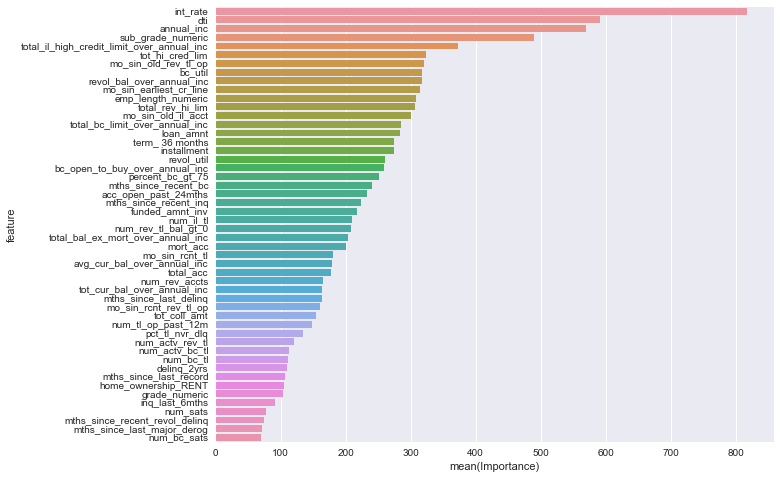

In [350]:
lgbm_importance = lgbm.feature_importance()
lgbm_importance = pd.DataFrame(lgbm_importance, index=train_loans.data.columns, 
                          columns=["Importance"])
lgbm_importance.sort_values('Importance', ascending = False, inplace=True)
lgbm_importance['feature'] = lgbm_importance.index
sns.barplot(y = 'feature', x = 'Importance', data= lgbm_importance.head(50) )
plt.savefig("LGBM-feature.png")

## XG Boost

In [351]:
#Parameters selected from cross validation in the next section
xg_est = loans_mf.xgboost.XGBClassifier(booster = 'gbtree',n_jobs=-1, silent=False,
                                        learning_rate=0.15, min_child_weight=1, max_depth=5, gamma=0.1, max_delta_step=1,
                                        subsample=0.8, colsample_bytree = 0.8,  scale_pos_weight=1, 
                                        objective='binary:logistic', eval_metric = 'auc', random_state=4,
                                        missing=None, n_estimators=300)
xg_est.fit(train_loans.data, train_loans.target, eval_metric = 'auc')
allmodelscores = allmodelscores.append(score_the_model(train_loans, test_loans, xg_est, model_key='XG Boost'), ignore_index=True)
allmodelscores.tail(1)

-----------------------------------------------------------------------------------------------------------
XG Boost


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
4,0.742511,0.783176,0.773401,0.79227,0.757735,0.778282,0.423825,0.51881,0.358237,0.858968,0.822125,0.899267,XG Boost,0.46583,0.536686


In [352]:
# XGBoost with over sampled training set
xg_est_smpled = loans_mf.xgboost.XGBClassifier(booster = 'gbtree',n_jobs=-1, silent=False,
                                        learning_rate=0.15, min_child_weight=1, max_depth=5, gamma=0.1, max_delta_step=1,
                                        subsample=0.8, colsample_bytree = 0.8,  scale_pos_weight=1, 
                                        objective='binary:logistic', eval_metric = 'auc', random_state=4,
                                        missing=None, n_estimators=300)
xg_est_smpled.fit(sampled_lr_loans.data, sampled_lr_loans.target, eval_metric = 'auc')
allmodelscores = allmodelscores.append(score_the_model(sampled_lr_loans, test_loans, xg_est_smpled, model_key='XG Boost with OverSampling'), ignore_index=True)
allmodelscores.tail(1)

-----------------------------------------------------------------------------------------------------------
XG Boost with OverSampling


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
5,0.741315,0.932173,0.771402,0.861804,0.755517,0.861524,0.41831,0.512611,0.353314,0.85775,0.820823,0.898155,XG Boost with OverSampling,0.463012,0.948336


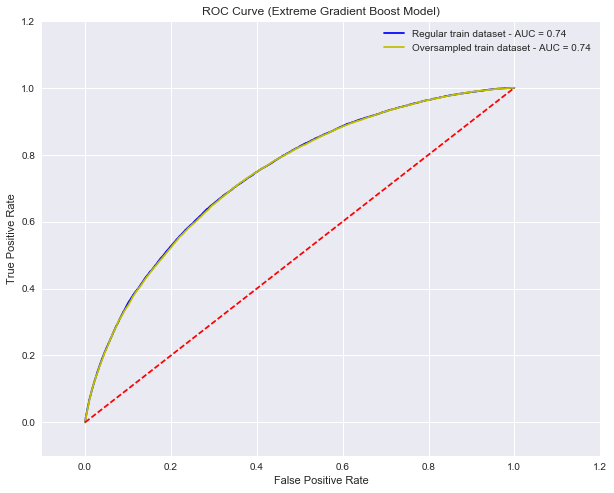

In [353]:
# ROC Curve
xg_fpr, xg_tpr, xg_threshold = roc_curve(np.array(test_loans.target),xg_est.predict_proba(test_loans.data)[:,1] )
xg_fpr_ovr, xg_tpr_ovr, xg_threshold_over = roc_curve(np.array(test_loans.target),xg_est_smpled.predict_proba(test_loans.data)[:,1])
xg_roc_auc = auc(xg_fpr, xg_tpr)
xg_roc_auc_ovr = auc(xg_fpr_ovr, xg_tpr_ovr)
plt.title('ROC Curve (Extreme Gradient Boost Model)')
plt.plot(xg_fpr, xg_tpr, 'b', label='Regular train dataset - AUC = %0.2f'% xg_roc_auc)
plt.plot(xg_fpr_ovr, xg_tpr_ovr, 'y', label='Oversampled train dataset - AUC = %0.2f'% xg_roc_auc_ovr)
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

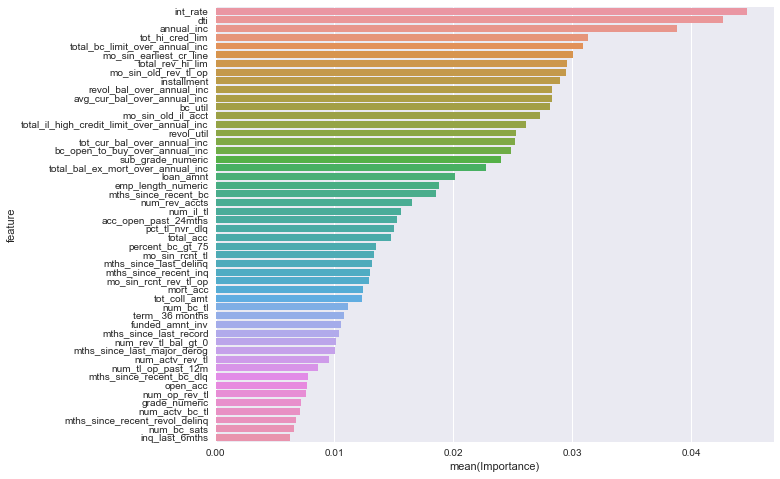

In [354]:
xg_importance = xg_est.feature_importances_
xg_importance = pd.DataFrame(xg_importance, index=train_loans.data.columns, 
                          columns=["Importance"])
xg_importance.sort_values('Importance', ascending = False, inplace=True)
xg_importance['feature'] = xg_importance.index
sns.barplot(y = 'feature', x = 'Importance', data= xg_importance.head(50) )
plt.savefig("xg-feature.png")

## Voting Ensemble

In [355]:
# A voting ensemble that will return a 'soft' voting - average of the predicted probabilities of each classifier. 
# Note: Not using sklearn's VotingClassifier as the Light GBM classifier that's used here is not a sklearn classifier, so the methods 
# do not generalize. So a custom implementation is done here.
rf_proba = rf_est.predict_proba(test_loans.data)[:,1]
lgbm_proba = lgbm.predict(test_loans.data)
xg_proba = xg_est.predict_proba(test_loans.data)[:,1]
final_proba_avg = (lgbm_proba + xg_proba + rf_proba) / 3
final_proba_max = np.max( np.array([ lgbm_proba, xg_proba, rf_proba ]), axis=0 )

final_predictions_avg = np.array([0 if p < 0.4 else 1 for p in final_proba_avg])
final_predictions_max = np.array([0 if p < 0.4 else 1 for p in final_proba_max])

In [356]:
tr_accuracy = '-'
te_accuracy = accuracy_score(np.array(test_loans.target), final_predictions_avg)
    
tr_auc = '-'
te_auc = roc_auc_score(np.array(test_loans.target), np.array(final_proba_avg), average = 'weighted')
    
tr_prec = '-'
te_prec = average_precision_score(np.array(test_loans.target), np.array(final_proba_avg), average = 'weighted')
    
tr_f1 = '-'
te_f1 = f1_score(np.array(test_loans.target), np.array(final_predictions_avg), average = 'weighted')

prec, recall, f1, support = precision_recall_fscore_support(np.array(test_loans.target), np.array(final_predictions_avg))
te_0_prec, te_1_prec = prec[0], prec[1]
te_0_rec, te_1_rec = recall[0], recall[1]
te_0_f1, te_1_f1 = f1[0], f1[1]
    
scores = pd.Series(['Voting Ensemble - Average voting',tr_accuracy,te_accuracy,tr_auc,te_auc,tr_prec,te_prec,tr_f1,te_f1, te_0_prec,te_1_prec,
                         te_0_rec, te_1_rec,te_0_f1, te_1_f1], ['Model','Accuracy (Train)', 'Accuracy (Test)', 'AUC (Train)', 'AUC (Test)',
                                        'Precision (Train)', 'Precision (Test)','F1-Weighted (Train)', 'F1-Weighted (Test)',
                                        'Label-Good Precision (Test)','Label-Bad Precision (Test)', 'Label-Good Recall (Test)',
                                        'Label-Bad Recall (Test)','Label-Good F1 (Test)','Label-Bad F1 (Test)'  ] )
allmodelscores = allmodelscores.append(scores, ignore_index=True)
allmodelscores.tail(1)

,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
6,0.741283,-,0.775236,-,0.75462,-,0.401655,0.527546,0.324273,0.861629,0.816566,0.911956,Voting Ensemble - Average voting,0.463397,-


In [357]:
tr_accuracy = '-'
te_accuracy = accuracy_score(np.array(test_loans.target), final_predictions_max)
    
tr_auc = '-'
te_auc = roc_auc_score(np.array(test_loans.target), np.array(final_proba_max), average = 'weighted')
    
tr_prec = '-'
te_prec = average_precision_score(np.array(test_loans.target), np.array(final_proba_max), average = 'weighted')
    
tr_f1 = '-'
te_f1 = f1_score(np.array(test_loans.target), np.array(final_predictions_max), average = 'weighted')

prec, recall, f1, support = precision_recall_fscore_support(np.array(test_loans.target), np.array(final_predictions_max))
te_0_prec, te_1_prec = prec[0], prec[1]
te_0_rec, te_1_rec = recall[0], recall[1]
te_0_f1, te_1_f1 = f1[0], f1[1]
    
scores = pd.Series(['Voting Ensemble - ArgMax voting',tr_accuracy,te_accuracy,tr_auc,te_auc,tr_prec,te_prec,tr_f1,te_f1, te_0_prec,te_1_prec,
                         te_0_rec, te_1_rec,te_0_f1, te_1_f1], ['Model','Accuracy (Train)', 'Accuracy (Test)', 'AUC (Train)', 'AUC (Test)',
                                        'Precision (Train)', 'Precision (Test)','F1-Weighted (Train)', 'F1-Weighted (Test)',
                                        'Label-Good Precision (Test)','Label-Bad Precision (Test)', 'Label-Good Recall (Test)',
                                        'Label-Bad Recall (Test)','Label-Good F1 (Test)','Label-Bad F1 (Test)'  ] )
allmodelscores = allmodelscores.append(scores, ignore_index=True)
allmodelscores.tail(1)

,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
7,0.737581,-,0.760263,-,0.754734,-,0.451751,0.482664,0.424559,0.84659,0.831685,0.862039,Voting Ensemble - ArgMax voting,0.461264,-


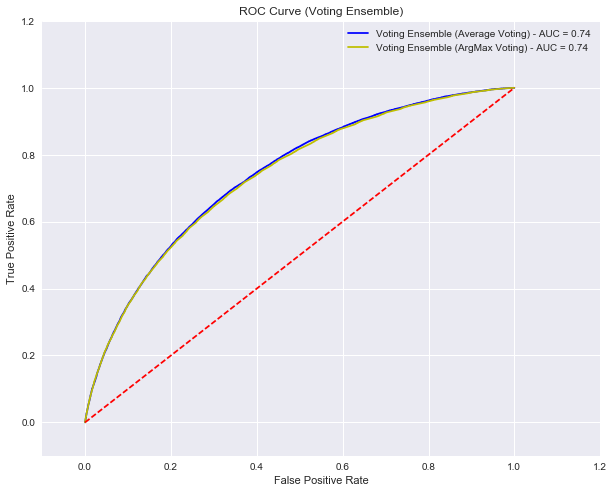

In [358]:
# ROC Curve
ve_fpr, ve_tpr, ve_threshold = roc_curve(np.array(test_loans.target),final_proba_avg )
vem_fpr, vem_tpr, vem_threshold = roc_curve(np.array(test_loans.target),final_proba_max )
ve_roc_auc = auc(ve_fpr, ve_tpr)
vem_roc_auc = auc(vem_fpr, vem_tpr)

plt.title('ROC Curve (Voting Ensemble)')
plt.plot(ve_fpr, ve_tpr, 'b', label='Voting Ensemble (Average Voting) - AUC = %0.2f'% ve_roc_auc)
plt.plot(vem_fpr, vem_tpr, 'y', label='Voting Ensemble (ArgMax Voting) - AUC = %0.2f'% vem_roc_auc)

plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Model Comparison

In [359]:
#See the results summary from all models
allmodelscores

,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
0,0.714497,1,0.764646,0.99998,0.739550,0.99998,0.355288,0.489760,0.278752,0.856048,0.806599,0.911956,Random Forest,0.423052,1
1,0.714236,1,0.749766,0.99997,0.742852,0.99997,0.421155,0.455945,0.391298,0.840382,0.823064,0.858444,Random Forest with Oversampling,0.424440,1
2,0.742971,0.768419,0.773039,0.784506,0.756491,0.769141,0.418322,0.518029,0.350801,0.859014,0.820726,0.901050,Light GBM,0.466543,0.507788
3,0.740690,0.926175,0.772852,0.85595,0.754941,0.855574,0.410675,0.517977,0.340200,0.859313,0.818819,0.904020,Light GBM with Oversampling,0.462486,0.944234
4,0.742511,0.783176,0.773401,0.79227,0.757735,0.778282,0.423825,0.518810,0.358237,0.858968,0.822125,0.899267,XG Boost,0.465830,0.536686
5,0.741315,0.932173,0.771402,0.861804,0.755517,0.861524,0.418310,0.512611,0.353314,0.857750,0.820823,0.898155,XG Boost with OverSampling,0.463012,0.948336
6,0.741283,-,0.775236,-,0.754620,-,0.401655,0.527546,0.324273,0.861629,0.816566,0.911956,Voting Ensemble - Average voting,0.463397,-
7,0.737581,-,0.760263,-,0.754734,-,0.451751,0.482664,0.424559,0.846590,0.831685,0.862039,Voting Ensemble - ArgMax voting,0.461264,-


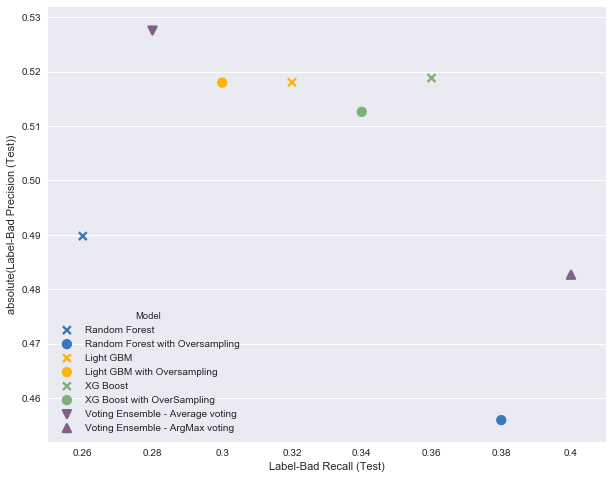

In [360]:
# Plot Precision & Recall for 'Bad' loans from all models
colors = ["windows blue", "windows blue", "amber", "amber", "faded green","faded green", "dusty purple", "dusty purple"]
ax = sns.pointplot('Label-Bad Recall (Test)', 'Label-Bad Precision (Test)', hue = 'Model', data = allmodelscores, 
                   estimator = np.abs, markers = ['x', 'o', 'x', 'o', 'x', 'o', 'v', '^'], 
                   palette = sns.xkcd_palette(colors))
ax.set_xticklabels(np.arange(0.26, 0.52, 0.02))
#ax.set_xticks(np.arange(0, 0.52, 0.02))
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 1)
plt.savefig('prec-recall-all.png')

C:\Users\Anu\Anaconda3\lib\site-packages\pandas\core\indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Anu\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


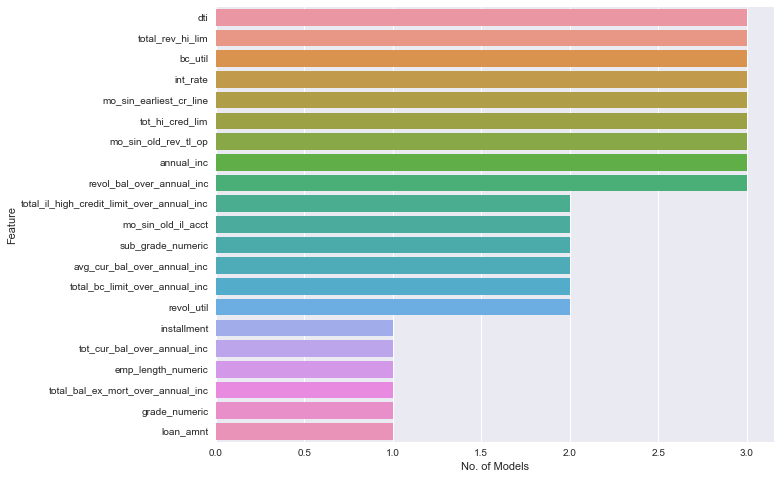

In [361]:
# Compare top 15 features across the three models
rf_top = rf_importance.head(15)
rf_top.loc[:,'Model'] = 'Random Forest'
xg_top = xg_importance.head(15)
xg_top.loc[:,'Model'] = 'XG Boost'
lgbm_top = lgbm_importance.head(15)
lgbm_top.loc[:,'Model'] = 'Light GBM'
frames = [rf_top, xg_top, lgbm_top]
top_features = pd.concat(frames, axis = 0)
#top_features = 
top = pd.DataFrame(top_features.feature.value_counts())
top['feature_name'] = top.index
ax = sns.barplot(x = 'feature', y = 'feature_name' ,data = top)
ax.set_xlabel('No. of Models')
ax.set_ylabel('Feature')
plt.savefig('Top-features.png')

### Evaluating models with respect to ROI 

In [362]:
#assuming the following.
# a) the return on investment (ROI) on each loan has been pre-calculated based on the actual repayment amount and funded amount. 
# b) Total ROI is sum of (ROI * amount invested in the loan) for all invested loans
# c) Total Invested amount is $300,000 and equally divided into each of the invested loan

# Scenario 1 - Loan default prediction model is not used and the investment is made equally on all loans in the test dataset
total_investment = 300000
inv_per_loan = total_investment / len(test_loans) 
total_roi = np.sum(loans.iloc[test_loans.index].roi_inv * inv_per_loan)
print ("Investing $%d in %d loans" %(total_investment, len(test_loans)))
print ("%d loans defaulted!" %len(test_loans[test_loans.target ==1]))
print( "ROI is $%d" %(total_roi))

Investing $300000 in 85552 loans
19903 loans defaulted!
ROI is $-1


In [363]:
# Scenario 2 - The XG Boost prediction model is used and the investment is made equally on all loan predicted to be 'Good' in the
# test dataset
xg_proba = xg_est.predict_proba(test_loans.data)[:,1]
xg_predictions = np.array([0 if p < 0.4 else 1 for p in xg_proba])

#Investing only in loans predicted to be 'Good'
xg_inv_loans = test_loans[xg_predictions == 0]
total_investment = 300000
inv_per_loan = total_investment / len(xg_inv_loans)

total_roi = np.sum(loans.iloc[xg_inv_loans.index].roi_inv * inv_per_loan)

print ("Investing $%d in %d loans" %(total_investment, len(xg_inv_loans)))
print ("%d loans defaulted!" %len(xg_inv_loans[xg_inv_loans.target ==1]))
print( "ROI is $%d" %(total_roi))

#Calculating potential revenue loss for LC
xg_not_inv_good_loans = test_loans[np.logical_and(xg_predictions == 1 , test_loans.target == 0)]

total_rev_loss = np.sum(loans.iloc[xg_not_inv_good_loans.index].roi_inv * xg_not_inv_good_loans.loan_amnt)
print ("%d loans did not default!" %len(xg_not_inv_good_loans))
print( "Potential total revenue loss is $%d" %(total_rev_loss))

Investing $300000 in 71809 loans
12773 loans defaulted!
ROI is $11142
6613 loans did not default!
Potential total revenue loss is $23076370


In [364]:
# Scenario 3 - The Voting Ensemble with max voting prediction model is used and the investment is made equally on all 
#loan predicted to be 'Good' in the test dataset


#Investing only in loans predicted to be 'Good'
ve_inv_loans = test_loans[final_predictions_max == 0]
total_investment = 300000
inv_per_loan = total_investment / len(ve_inv_loans)

total_roi = np.sum(loans.iloc[ve_inv_loans.index].roi_inv * inv_per_loan)

print ("Investing $%d in %d loans" %(total_investment, len(ve_inv_loans)))
print ("%d loans defaulted!" %len(ve_inv_loans[ve_inv_loans.target ==1]))
print( "ROI is $%d" %(total_roi))

#Calculating potential revenue loss for LC
ve_not_inv_good_loans = test_loans[np.logical_and(final_predictions_max == 1, test_loans.target == 0)]


total_rev_loss = np.sum(loans.iloc[ve_not_inv_good_loans.index].roi_inv * ve_not_inv_good_loans.loan_amnt)
print ("%d loans did not default!" %len(ve_not_inv_loans[ve_not_inv_loans.target ==0]))
print( "Potential total revenue loss is $%d" %(total_rev_loss))

Investing $300000 in 68045 loans
11453 loans defaulted!
ROI is $12526
9027 loans did not default!
Potential total revenue loss is $32142797


In [365]:
#How the 'Good' loans predicted by XG Boost & Voting Ensemble models vary across grades.
xg_inv_loans = pdml.ModelFrame(loans.iloc[xg_inv_loans.index])
ve_inv_loans = pdml.ModelFrame(loans.iloc[ve_inv_loans.index])
all_inv_loans = pdml.ModelFrame(loans.iloc[test_loans.index])

xg_by_grade = xg_inv_loans.groupby(['grade', '.target']).size()
xg_by_grade = xg_by_grade.unstack()
xg_by_grade['Model'] = 'Selected by XG Boost'

ve_by_grade = ve_inv_loans.groupby(['grade', '.target']).size()
ve_by_grade = ve_by_grade.unstack()
ve_by_grade['Model'] = 'Selected by Voting Ensemble - Argmax'

all_by_grade = all_inv_loans.groupby(['grade', '.target']).size()
all_by_grade = all_by_grade.unstack()
all_by_grade['Model'] = 'Select All - No predictive model'

by_grade = pd.concat([xg_by_grade, ve_by_grade, all_by_grade] , axis = 0)
by_grade.reset_index(inplace= True)
by_grade.columns.name = None
by_grade.rename(columns = {0 : 'Good', 1: 'Bad'}, inplace=True)
by_grade['Total'] = by_grade.Good + by_grade.Bad

by_grade

,grade,Good,Bad,Model,Total
0,A,11973,945,Selected by XG Boost,12918
1,B,21118,3578,Selected by XG Boost,24696
2,C,16135,4668,Selected by XG Boost,20803
3,D,7148,2464,Selected by XG Boost,9612
4,E,2079,840,Selected by XG Boost,2919
5,F,507,233,Selected by XG Boost,740
6,G,76,45,Selected by XG Boost,121
7,A,11973,945,Selected by Voting Ensemble - Argmax,12918
8,B,21062,3554,Selected by Voting Ensemble - Argmax,24616
9,C,15365,4234,Selected by Voting Ensemble - Argmax,19599


(0, 30000)

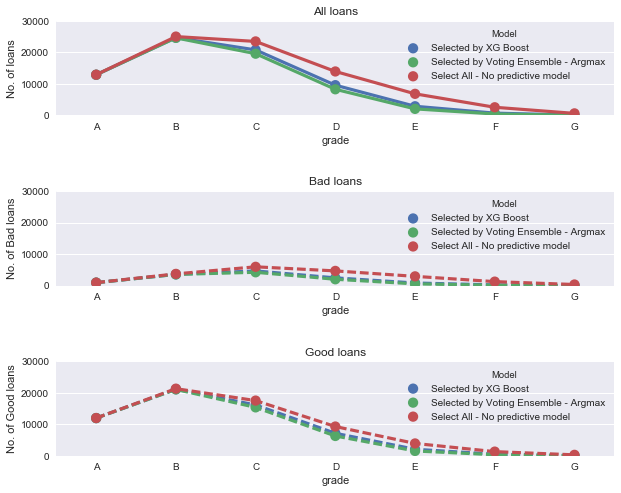

In [366]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
plt.subplots_adjust(hspace = 0.8)
ax1 = sns.pointplot('grade',  'Total', hue = 'Model', data = by_grade, ax = ax1 )
ax1.set_ylabel('No. of loans')
ax1.set_title( 'All loans')
ax1.set_ylim(0, 30000)
sns.pointplot('grade','Bad', hue = 'Model', data = by_grade, linestyles= '--', ax = ax2 )
ax2.set_ylabel('No. of Bad loans')
ax2.set_title( 'Bad loans')
ax2.set_ylim(0, 30000)
sns.pointplot('grade','Good', hue = 'Model', data = by_grade, linestyles= '--', ax = ax3 )
ax3.set_ylabel('No. of Good loans')
ax3.set_title( 'Good loans')
ax3.set_ylim(0, 30000)

### Hyper Parameter tuning for Light GBM
 

In [48]:
#initialize scores list and parameter values
mini_train_lgb = lgb.Dataset(mini_train_loans.data, label=mini_train_loans.target)


In [50]:
lgbmscores = pd.DataFrame()
num_leaves = [300, 500]
max_depth = [5, 7]
param = {'objective':'binary', 'metric' :['auc', 'f1_weighted'], 
        'num_leaves': 500, 'max_depth' : 7, 'learning_rate': 0.15, 'max_bin': 200, 'min_data_in_leaf' : 350}
#Test 1 - num_leaves and max_depth . Fix these first as they have the maximum impact
for param1_val in num_leaves  :
    param.update(num_leaves = param1_val)
    for param2_val in max_depth :
        param.update(max_depth = param2_val)
        lgbm_cv=lgb.train(param,mini_train_lgb,num_round)
        lgbmscores = lgbmscores.append(score_the_model(mini_train_loans, mini_test_loans, lgbm_cv,param, use_PredictProba=False), 
                          ignore_index=True)

lgbmscores

-----------------------------------------------------------------------------------------------------------
{'objective': 'binary', 'metric': ['auc', 'f1_weighted'], 'num_leaves': 300, 'max_depth': 5, 'learning_rate': 0.15, 'max_bin': 200, 'min_data_in_leaf': 350, 'verbose': 1}
-----------------------------------------------------------------------------------------------------------
{'objective': 'binary', 'metric': ['auc', 'f1_weighted'], 'num_leaves': 300, 'max_depth': 7, 'learning_rate': 0.15, 'max_bin': 200, 'min_data_in_leaf': 350, 'verbose': 1}
-----------------------------------------------------------------------------------------------------------
{'objective': 'binary', 'metric': ['auc', 'f1_weighted'], 'num_leaves': 500, 'max_depth': 5, 'learning_rate': 0.15, 'max_bin': 200, 'min_data_in_leaf': 350, 'verbose': 1}
-----------------------------------------------------------------------------------------------------------
{'objective': 'binary', 'metric': ['auc', 'f1_weighted'

,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
0,0.714950,0.885589,0.75875,0.851104,0.746610,0.844032,0.393463,0.454282,0.347007,0.84943,0.822108,0.878631,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.408025,0.732005
1,0.706993,0.946102,0.75375,0.899271,0.741817,0.896273,0.383476,0.440345,0.339616,0.84615,0.819732,0.874328,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.396969,0.863537
2,0.714950,0.885589,0.75875,0.851104,0.746610,0.844032,0.393463,0.454282,0.347007,0.84943,0.822108,0.878631,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.408025,0.732005
3,0.706993,0.946102,0.75375,0.899271,0.741817,0.896273,0.383476,0.440345,0.339616,0.84615,0.819732,0.874328,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.396969,0.863537


Based on the above and prioritizing Test AUC score, fixing num_leaves to be 300 and max_depth = 5 for next level of tuning for the remaining parameters

In [51]:
lgbmscores = pd.DataFrame()
learning_rate = [0.05, 0.10, 0.15]
min_data_in_leaf = [250, 300, 350]

param = {'objective':'binary', 'metric' :['auc', 'f1_weighted'], 
        'num_leaves': 300, 'max_depth' : 5, 'learning_rate': 0.15, 'max_bin': 200, 'min_data_in_leaf' : 350}
#Test 1 - num_leaves and max_depth . Fix these first as they have the maximum impact
for param1_val in learning_rate  :
    param.update(learning_rate = param1_val)
    for param2_val in min_data_in_leaf :
        param.update(min_data_in_leaf = param2_val)
        lgbm_cv=lgb.train(param,mini_train_lgb,num_round)
        lgbmscores = lgbmscores.append(score_the_model(mini_train_loans, mini_test_loans, lgbm_cv,param, use_PredictProba=False), 
                          ignore_index=True)

lgbmscores

-----------------------------------------------------------------------------------------------------------
{'objective': 'binary', 'metric': ['auc', 'f1_weighted'], 'num_leaves': 300, 'max_depth': 5, 'learning_rate': 0.05, 'max_bin': 200, 'min_data_in_leaf': 250, 'verbose': 1}
-----------------------------------------------------------------------------------------------------------
{'objective': 'binary', 'metric': ['auc', 'f1_weighted'], 'num_leaves': 300, 'max_depth': 5, 'learning_rate': 0.05, 'max_bin': 200, 'min_data_in_leaf': 300, 'verbose': 1}
-----------------------------------------------------------------------------------------------------------
{'objective': 'binary', 'metric': ['auc', 'f1_weighted'], 'num_leaves': 300, 'max_depth': 5, 'learning_rate': 0.05, 'max_bin': 200, 'min_data_in_leaf': 350, 'verbose': 1}
-----------------------------------------------------------------------------------------------------------
{'objective': 'binary', 'metric': ['auc', 'f1_weighted'

,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
0,0.727024,0.823788,0.768583,0.813875,0.752834,0.801436,0.395384,0.481187,0.335551,0.856907,0.822209,0.894663,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.427539,0.608526
1,0.728222,0.818430,0.771083,0.810562,0.756442,0.797552,0.407080,0.489362,0.348485,0.858161,0.824978,0.894125,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.428512,0.598055
2,0.727561,0.816288,0.770750,0.809667,0.755761,0.796821,0.404417,0.488238,0.345159,0.858057,0.824328,0.894663,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.427093,0.592845
3,0.718623,0.869008,0.762000,0.840021,0.748037,0.831328,0.390525,0.462121,0.338137,0.852128,0.821257,0.885410,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.416235,0.697447
4,0.721060,0.863097,0.765917,0.836271,0.752709,0.827198,0.403483,0.474289,0.351072,0.854388,0.824347,0.886701,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.416689,0.685631
5,0.720048,0.857114,0.766333,0.834208,0.752301,0.824978,0.399829,0.475076,0.345159,0.854925,0.823400,0.888961,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.416233,0.674902
6,0.713453,0.898968,0.757500,0.862313,0.744262,0.856207,0.384518,0.449555,0.335920,0.849004,0.819904,0.880245,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.408107,0.761917
7,0.713877,0.891561,0.760667,0.855167,0.748150,0.848368,0.395623,0.459433,0.347376,0.850790,0.822584,0.880998,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.405589,0.743757
8,0.714950,0.885589,0.758750,0.851104,0.746610,0.844032,0.393463,0.454282,0.347007,0.849430,0.822108,0.878631,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.408025,0.732005


Based on the above and prioritizing Test AUC score, fixing learning_rate to be 0.05 and min_data_in_leaf to 300 for next level of tuning for the remaining parameters

In [52]:
max_bin = [100, 150, 200]
lgbmscores = pd.DataFrame()

param = {'objective':'binary', 'metric' :['auc', 'f1_weighted'], 
        'num_leaves': 300, 'max_depth' : 5, 'learning_rate': 0.05, 'max_bin': 200, 'min_data_in_leaf' : 300}
#Test 1 - num_leaves and max_depth . Fix these first as they have the maximum impact
for param1_val in max_bin  :
    param.update(max_bin = param1_val)
    lgbm_cv=lgb.train(param,mini_train_lgb,num_round)
    lgbmscores = lgbmscores.append(score_the_model(mini_train_loans, mini_test_loans, lgbm_cv,param, use_PredictProba=False), 
                          ignore_index=True)

lgbmscores

-----------------------------------------------------------------------------------------------------------
{'objective': 'binary', 'metric': ['auc', 'f1_weighted'], 'num_leaves': 300, 'max_depth': 5, 'learning_rate': 0.05, 'max_bin': 100, 'min_data_in_leaf': 300, 'verbose': 1}
-----------------------------------------------------------------------------------------------------------
{'objective': 'binary', 'metric': ['auc', 'f1_weighted'], 'num_leaves': 300, 'max_depth': 5, 'learning_rate': 0.05, 'max_bin': 150, 'min_data_in_leaf': 300, 'verbose': 1}
-----------------------------------------------------------------------------------------------------------
{'objective': 'binary', 'metric': ['auc', 'f1_weighted'], 'num_leaves': 300, 'max_depth': 5, 'learning_rate': 0.05, 'max_bin': 200, 'min_data_in_leaf': 300, 'verbose': 1}


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
0,0.728222,0.81843,0.771083,0.810562,0.756442,0.797552,0.40708,0.489362,0.348485,0.858161,0.824978,0.894125,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.428512,0.598055
1,0.728222,0.81843,0.771083,0.810562,0.756442,0.797552,0.40708,0.489362,0.348485,0.858161,0.824978,0.894125,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.428512,0.598055
2,0.728222,0.81843,0.771083,0.810562,0.756442,0.797552,0.40708,0.489362,0.348485,0.858161,0.824978,0.894125,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.428512,0.598055


The parameter max_bin seems to give the same result for different values, so taking the min value for the same in the tuned model.

### Hyper Parameter tuning for XG Boost

In [67]:
#Test 1 - no of estimators, max_depth and learning rate
xg_cv_scores = pd.DataFrame()
xg_est_cv = loans_mf.xgboost.XGBClassifier(booster = 'gbtree',n_jobs=-1, silent=False,
                                        learning_rate=0.15, min_child_weight=1, max_depth=5, gamma=0.1, max_delta_step=1,
                                        subsample=0.8, colsample_bytree = 0.8, scale_pos_weight=1, 
                                        objective='binary:logistic', eval_metric = 'auc', random_state=4,
                                        missing=None, n_estimators=300)

n_estimators = [300, 400]
max_depth = [4, 5, 7]
learning_rate = [0.05, 0.10]
#param_1 = param_test1.ke
for param1_val in n_estimators  :
    xg_est_cv.set_params(n_estimators = param1_val)
    for param2_val in max_depth :
        xg_est_cv.set_params(max_depth = param2_val)
        for param3_val in learning_rate :
            xg_est_cv.set_params(learning_rate = param3_val)
            xg_est_cv.fit(mini_train_loans.data, mini_train_loans.target, eval_metric = 'auc')
            xg_cv_scores = xg_cv_scores.append (score_the_model(mini_train_loans, mini_test_loans, xg_est_cv, 
                                                                model_key= xg_est_cv.get_params(), use_PredictProba=True), 
                                                ignore_index = True)
xg_cv_scores
            

-----------------------------------------------------------------------------------------------------------
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 300, 'n_jobs': -1, 'nthread': -1, 'objective': 'binary:logistic', 'random_state': 4, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 4, 'silent': False, 'subsample': 0.8, 'eval_metric': 'auc'}
-----------------------------------------------------------------------------------------------------------
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 300, 'n_jobs': -1, 'nthread': -1, 'objective': 'binary:logistic', 'random_state': 4, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight'

,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
0,0.727447,0.783953,0.772750,0.794271,0.753956,0.777074,0.388153,0.494003,0.319660,0.860462,0.820373,0.904670,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.429225,0.540710
1,0.727450,0.815726,0.769333,0.811500,0.753419,0.798492,0.396161,0.483493,0.335551,0.857437,0.822367,0.895632,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.430463,0.602520
2,0.726642,0.817484,0.772667,0.811583,0.755391,0.797420,0.396193,0.493929,0.330746,0.859973,0.822242,0.901334,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.427024,0.603578
3,0.722650,0.860797,0.764750,0.836646,0.749465,0.826710,0.389358,0.469484,0.332594,0.854312,0.820887,0.890575,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.426156,0.691800
4,0.725773,0.907652,0.766917,0.869146,0.750470,0.862140,0.387831,0.475577,0.327421,0.856055,0.820460,0.894878,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.428685,0.788533
5,0.715186,0.963796,0.762500,0.922375,0.746606,0.919767,0.380973,0.462065,0.324095,0.853062,0.818947,0.890144,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.412475,0.914107
6,0.727917,0.796563,0.771417,0.800271,0.754071,0.784584,0.393007,0.489796,0.328160,0.859196,0.821537,0.900473,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.429218,0.564797
7,0.726453,0.833477,0.769000,0.821583,0.754760,0.810043,0.404639,0.483077,0.348115,0.856700,0.824478,0.891543,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.427396,0.637919
8,0.726748,0.836133,0.771167,0.821604,0.754464,0.809334,0.395952,0.489130,0.332594,0.858847,0.822244,0.898859,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.426917,0.639772
9,0.720161,0.886827,0.763417,0.854479,0.748429,0.846640,0.388015,0.465598,0.332594,0.853365,0.820602,0.888853,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.421758,0.744982


In [68]:
#Getting param values for the cv with the best AUC Test score, no of estimators = 400, max_depth = 4 and learning rate = 0.05
xg_cv_scores.loc[6]['Model']

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'eval_metric': 'auc',
 'gamma': 0.1,
 'learning_rate': 0.05,
 'max_delta_step': 1,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 400,
 'n_jobs': -1,
 'nthread': -1,
 'objective': 'binary:logistic',
 'random_state': 4,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 4,
 'silent': False,
 'subsample': 0.8}

In [71]:
#Test 2 - min_child_weight, max_delta_step and gamma
xg_cv_scores = pd.DataFrame()
xg_est_cv = loans_mf.xgboost.XGBClassifier(booster = 'gbtree',n_jobs=-1, silent=False,
                                        learning_rate=0.05, min_child_weight=1, max_depth=4, gamma=0.1, max_delta_step=1,
                                        subsample=0.8, colsample_bytree = 0.8, scale_pos_weight=1, 
                                        objective='binary:logistic', eval_metric = 'auc', random_state=4,
                                        missing=None, n_estimators=400)

min_child_weight = [1,2]
max_delta_step = [1,2]
gamma = [0.1, 0.2]
#param_1 = param_test1.ke
for param1_val in min_child_weight  :
    xg_est_cv.set_params(min_child_weight = param1_val)
    for param2_val in max_delta_step :
        xg_est_cv.set_params(max_delta_step = param2_val)
        for param3_val in gamma :
            xg_est_cv.set_params(gamma = param3_val)
            xg_est_cv.fit(mini_train_loans.data, mini_train_loans.target, eval_metric = 'auc')
            xg_cv_scores = xg_cv_scores.append (score_the_model(mini_train_loans, mini_test_loans, xg_est_cv, 
                                                                model_key= xg_est_cv.get_params(), use_PredictProba=True), 
                                                ignore_index = True)
xg_cv_scores.sort_values('AUC (Test)', ascending = False)

-----------------------------------------------------------------------------------------------------------
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 400, 'n_jobs': -1, 'nthread': -1, 'objective': 'binary:logistic', 'random_state': 4, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 4, 'silent': False, 'subsample': 0.8, 'eval_metric': 'auc'}
-----------------------------------------------------------------------------------------------------------
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.05, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 400, 'n_jobs': -1, 'nthread': -1, 'objective': 'binary:logistic', 'random_state': 4, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight

,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
0,0.727917,0.796563,0.771417,0.800271,0.754071,0.784584,0.393007,0.489796,0.328160,0.859196,0.821537,0.900473,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.429218,0.564797
1,0.727632,0.796867,0.769333,0.800188,0.751804,0.784516,0.387340,0.482892,0.323356,0.857920,0.820279,0.899182,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.428503,0.564911
3,0.727553,0.801184,0.770833,0.803729,0.753616,0.788743,0.392399,0.487912,0.328160,0.858786,0.821415,0.899720,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.430931,0.572616
2,0.727273,0.800582,0.769417,0.802604,0.751418,0.787479,0.384974,0.482989,0.320030,0.858110,0.819732,0.900258,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.429279,0.571332
4,0.727225,0.795455,0.768667,0.799104,0.750987,0.783498,0.385024,0.480642,0.321138,0.857539,0.819761,0.898967,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.427967,0.561317
6,0.727146,0.800175,0.769500,0.801937,0.752822,0.786804,0.392355,0.483749,0.330007,0.857775,0.821450,0.897461,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.429961,0.570110
7,0.727141,0.800171,0.769500,0.801937,0.752822,0.786804,0.392355,0.483749,0.330007,0.857775,0.821450,0.897461,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.429941,0.570120
5,0.726910,0.795668,0.769583,0.798958,0.751949,0.783378,0.387326,0.483675,0.322986,0.858111,0.820269,0.899613,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.428184,0.561927


In [72]:
#Getting param values for the cv with the best AUC Test score, min_child_weight = 1, max_delta_step = 1 and gamma = 0.1
xg_cv_scores.loc[0]['Model']

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'eval_metric': 'auc',
 'gamma': 0.1,
 'learning_rate': 0.05,
 'max_delta_step': 1,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 400,
 'n_jobs': -1,
 'nthread': -1,
 'objective': 'binary:logistic',
 'random_state': 4,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 4,
 'silent': False,
 'subsample': 0.8}

In [73]:
#Test 3 - subsample, colsample_bytree and colsample_bylevel
xg_cv_scores = pd.DataFrame()
xg_est_cv = loans_mf.xgboost.XGBClassifier(booster = 'gbtree',n_jobs=-1, silent=False,
                                        learning_rate=0.05, min_child_weight=1, max_depth=4, gamma=0.1, max_delta_step=1,
                                        subsample=0.8, colsample_bytree = 0.8, scale_pos_weight=1, 
                                        objective='binary:logistic', eval_metric = 'auc', random_state=4,
                                        missing=None, n_estimators=400)

subsample = [0.6, 0.8]
colsample_bytree = [0.6,0.8]
colsample_bylevel = [0.8, 1]
#param_1 = param_test1.ke
for param1_val in subsample  :
    xg_est_cv.set_params(subsample = param1_val)
    for param2_val in colsample_bytree :
        xg_est_cv.set_params(colsample_bytree = param2_val)
        for param3_val in colsample_bylevel :
            xg_est_cv.set_params(colsample_bylevel = param3_val)
            xg_est_cv.fit(mini_train_loans.data, mini_train_loans.target, eval_metric = 'auc')
            xg_cv_scores = xg_cv_scores.append (score_the_model(mini_train_loans, mini_test_loans, xg_est_cv, 
                                                                model_key= xg_est_cv.get_params(), use_PredictProba=True), 
                                                ignore_index = True)
xg_cv_scores.sort_values('AUC (Test)', ascending = False)

-----------------------------------------------------------------------------------------------------------
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 400, 'n_jobs': -1, 'nthread': -1, 'objective': 'binary:logistic', 'random_state': 4, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 4, 'silent': False, 'subsample': 0.6, 'eval_metric': 'auc'}
-----------------------------------------------------------------------------------------------------------
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 1, 'missing': None, 'n_estimators': 400, 'n_jobs': -1, 'nthread': -1, 'objective': 'binary:logistic', 'random_state': 4, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weig

,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
6,0.728857,0.794504,0.771417,0.800229,0.754071,0.784667,0.393007,0.489796,0.328160,0.859196,0.821537,0.900473,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.429907,0.558448
7,0.727917,0.796563,0.771417,0.800271,0.754071,0.784584,0.393007,0.489796,0.328160,0.859196,0.821537,0.900473,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.429218,0.564797
4,0.727893,0.791892,0.770667,0.799167,0.752890,0.783345,0.388988,0.487208,0.323725,0.858843,0.820623,0.900796,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.431384,0.556726
3,0.727612,0.794996,0.768917,0.799333,0.752025,0.783846,0.389879,0.481784,0.327421,0.857466,0.820884,0.897461,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.431432,0.560716
5,0.727357,0.794178,0.770333,0.798958,0.753078,0.783249,0.391074,0.486264,0.327051,0.858478,0.821120,0.899397,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.428289,0.559610
2,0.727330,0.793991,0.770750,0.799479,0.753353,0.783902,0.391237,0.487590,0.326681,0.858785,0.821145,0.900043,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.429709,0.557341
1,0.726845,0.793443,0.769750,0.798792,0.753066,0.783327,0.392881,0.484553,0.330377,0.857936,0.821566,0.897676,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.428785,0.558334
0,0.725839,0.791880,0.770833,0.798687,0.752870,0.782268,0.388345,0.487709,0.322616,0.859003,0.820470,0.901334,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.427337,0.554849


In [74]:
#Getting param values for the cv with the best AUC Test score, subsample = 0.8, colsample_bylevel = 0.8, colsample_bytree = 0.8
xg_cv_scores.loc[6]['Model']

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.8,
 'colsample_bytree': 0.8,
 'eval_metric': 'auc',
 'gamma': 0.1,
 'learning_rate': 0.05,
 'max_delta_step': 1,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 400,
 'n_jobs': -1,
 'nthread': -1,
 'objective': 'binary:logistic',
 'random_state': 4,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 4,
 'silent': False,
 'subsample': 0.8}

### Hyper Parameter tuning for RandomForest

In [ ]:
rf_est_cv = loans_mf.ensemble.RandomForestClassifier(n_estimators = 200, criterion = 'gini', class_weight = 'balanced',
                                                 max_depth = None, min_samples_split = 2, min_samples_leaf = 1, min_weight_fraction_leaf = 0, 
                                                  max_features = 'auto', max_leaf_nodes = None, oob_score = True )



In [105]:
#Test 1 -n_estimators & max_depth
rf_est_cv = loans_mf.ensemble.RandomForestClassifier(n_estimators = 200, criterion = 'gini', class_weight = 'balanced',
                                                 max_depth = None, min_samples_split = 2, min_samples_leaf = 1, min_weight_fraction_leaf = 0, 
                                                  max_features = 'auto', max_leaf_nodes = None, oob_score = True )
rf_est_cv_scores = pd.DataFrame()

n_estimators = [ 200, 300, 400]
max_depth = [7, 9]
for param1_val in n_estimators  :
    rf_est_cv.set_params(n_estimators = param1_val)
    for param2_val in max_depth :
        rf_est_cv.set_params(max_depth = param2_val)
        rf_est_cv.fit(mini_train_loans.data, mini_train_loans.target)
        rf_est_cv_scores = rf_est_cv_scores.append (score_the_model(mini_train_loans, mini_test_loans, rf_est_cv, 
                                                                model_key= 'n_estimators= '+str(param1_val)+' max_depth= '+str(param2_val), use_PredictProba=True), 
                                                ignore_index = True)
rf_est_cv_scores.sort_values('AUC (Test)', ascending = False)

-----------------------------------------------------------------------------------------------------------
n_estimators= 200 max_depth= 7
-----------------------------------------------------------------------------------------------------------
n_estimators= 200 max_depth= 9
-----------------------------------------------------------------------------------------------------------
n_estimators= 300 max_depth= 7
-----------------------------------------------------------------------------------------------------------
n_estimators= 300 max_depth= 9
-----------------------------------------------------------------------------------------------------------
n_estimators= 400 max_depth= 7
-----------------------------------------------------------------------------------------------------------
n_estimators= 400 max_depth= 9


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
3,0.712902,0.801829,0.570000,0.610583,0.602386,0.638809,0.452113,0.317193,0.786770,0.646139,0.890885,0.506886,n_estimators= 300 max_depth= 9,0.409471,0.550217
5,0.712888,0.801922,0.568000,0.608938,0.600304,0.637193,0.451893,0.316499,0.789727,0.643515,0.891578,0.503443,n_estimators= 400 max_depth= 9,0.409552,0.551642
1,0.712641,0.801402,0.569417,0.609958,0.601749,0.638219,0.452358,0.317135,0.788618,0.645245,0.891482,0.505595,n_estimators= 200 max_depth= 9,0.409234,0.550970
2,0.710958,0.752031,0.541583,0.561333,0.572331,0.589897,0.445631,0.306360,0.817073,0.609221,0.896508,0.461373,n_estimators= 300 max_depth= 7,0.406790,0.478327
4,0.710830,0.751997,0.539250,0.560104,0.569974,0.588579,0.443930,0.304961,0.815595,0.606673,0.895234,0.458791,n_estimators= 400 max_depth= 7,0.407016,0.477265
0,0.710416,0.751508,0.541333,0.560250,0.572160,0.588835,0.444937,0.305964,0.815225,0.609202,0.895616,0.461588,n_estimators= 200 max_depth= 7,0.407032,0.476707


From the above , there is not a major difference in scores even if the no of trees is more than 200. So it can be fixed at 200 to save execution time. Same is the case with max_depth, the default param value can be accepted.

In [106]:
#Test 2 -max_features
rf_est_cv = loans_mf.ensemble.RandomForestClassifier(n_estimators = 300, criterion = 'gini', class_weight = 'balanced',
                                                 max_depth = None, min_samples_split = 2, min_samples_leaf = 1, min_weight_fraction_leaf = 0, 
                                                  max_features = 'auto', max_leaf_nodes = None, oob_score = True )
rf_est_cv_scores = pd.DataFrame()

max_features = [14, 20, 30]
for param1_val in max_features  :
    rf_est_cv.set_params(max_features = param1_val)
    rf_est_cv.fit(mini_train_loans.data, mini_train_loans.target)
    rf_est_cv_scores = rf_est_cv_scores.append (score_the_model(mini_train_loans, mini_test_loans, rf_est_cv, 
                                                                model_key= 'max_features= '+str(param1_val), use_PredictProba=True), 
                                                ignore_index = True)
rf_est_cv_scores.sort_values('AUC (Test)', ascending = False)

-----------------------------------------------------------------------------------------------------------
max_features= 14
-----------------------------------------------------------------------------------------------------------
max_features= 20
-----------------------------------------------------------------------------------------------------------
max_features= 30


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
1,0.714334,1.0,0.767417,1.0,0.739477,1.0,0.327632,0.470588,0.251293,0.859388,0.808053,0.917689,max_features= 20,0.405573,1.0
2,0.714327,1.0,0.766750,1.0,0.741401,1.0,0.339703,0.469667,0.266075,0.858357,0.810261,0.912524,max_features= 30,0.408486,1.0
0,0.712432,1.0,0.769750,1.0,0.740342,1.0,0.325275,0.479482,0.246120,0.861191,0.807747,0.922208,max_features= 14,0.404902,1.0


Increasing max_features to be more than the default sqrt(no of features) doesn't improve the test performance much. So the default parameter value can be accepted.